 ## Welcome to the VAME behaviour analysis lab
 
In this notebook we want to teach you a state-of-the-art deep learning method for behavior quantification called
Variational Animal Motion Embedding ([VAME](https://github.com/LINCellularNeuroscience/VAME)). This method is based on artificial recurrent neural networks and makes use of the powerful [variational autoencoder](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) framework.

## Part 0: Setting up the environment  and data alignment

In [6]:
# import of necessary functions
import sys
sys.path.append("/home/lindoscope/VAME")
sys.path.append("/home/lindoscope/lindoscope-2021/src/W1D3_Behavior_Analysis")

import numpy as np
import matplotlib.pyplot as plt
from display_video import play_motif_video

import vame

Real data:
Locate your data from linstore and copy it to your lindoscopeuser home directory.

Backup data:
Copy the "video-1.mp4" and "video-1.csv" from  the linstore to your lindoscopeuser home directory.


In [ ]:
# Set project name
project = "Lindoscope-VAME"

# set working directory
working_directory = "/home/pbauer/VAME"

# specifying path to example video, make sure this is the right path to your video file
videos = ['/home/pbauer/DATA/video-1.mp4']

In [ ]:
# Step 1: Initialize your project
config = vame.init_new_project(project=project, videos=videos, working_directory=working_directory)

In [7]:
# reinitialize config - set the path to your path
config = "/home/pbauer/VAME/Lindoscope-VAME-Aug31-2021/config.yaml"

Copy your csv file from DLC into the videos/pose_estimation folder inside the VAME directory.

After initialization of the project, please go to your folder and move video-1.csv into \videos\pose_estimation\ in your VAME project folder.

#### Egocentrical alignment
Currently, the recorded open-field data is in an allocentric representation. This means, our DeepLabCut x-y-coordinates are representing the location within the arena instead of the kinematis of the mouse movements. Therefore, we align our dataset egocentrical in the next step.

In [ ]:
# Step 2: Egocentric alignment of the input data
# pose_ref_index: list of reference coordinate indices for alignment
# Example: 0: snout, 1: forehand_left, 2: forehand_right, 3: hindleft, 4: hindright, 5: tail
vame.egocentric_alignment(config, pose_ref_index=[0,5])

After the alignment, we can inspect it via plotting an example trace:

In [ ]:
# load data
path_to_trajectory = "/home/pbauer/VAME/Lindoscope-VAME-Aug31-2021/data/video-1/video-1-PE-seq.npy"
trajectory = np.load(path_to_trajectory)

# set plotting configuration
points = 3000
start = np.random.choice(trajectory.shape[1] - points)
end = start + points
window=slice(start,end)

# plotting
plt.figure(figsize=(20,10))
plt.plot(trajectory[:,window].T)

## Part 1: Training a VAME model
This part of the notebook creates a training set from the egocentric aligned time series and initializes a VAME model to learn a lower dimensional embedding of the input data, which hopefully captures spatiotemporal characteristics of the input data to then identify behavioral motifs. 

First, we will create a training dataset which only takes a few moments. Then, we initialize a VAME model and let this model train for a few epochs. If you are using your own dataset, please talk to your TA about how long you should train the model. If you using the example dataset, train the model for about 30 epochs (~5 min).

In [ ]:
# create the training set for the VAME model
vame.create_trainset(config)

In [ ]:
vame.train_model(config)

After we trained our model, its time to evuluate its performance. As VAME is an unsupervised model, we don't have a ground truth to check its accuracy. What we can check, however, is its capability to reconstruct input signals. In a later step, we sample from its embedding distribution to further investigate the qualitiy of the learned representation.

In [ ]:
# Evaluate model
vame.evaluate_model(config)

If you see that the red dotted lines in the reconstruction panel follow the black lines, we can assume that the model learned a proper embedding space. The next part of this notebook is concerend with inference and obtaining behavioral motifs.

## Part 2: Inference of behavioral motifs
To infer behavioral motifs, the trained model runs on the entire dataset and embeds spatiotemporal characteristics into a lower dimensional representation or latent vectors. Using the latent vector information, a k-Means clustering then infers a cluster assignment which represents the motifs. 

Note, that the newest VAME version uses a Hidden-Markov-Model (HMM) to infer hidden states from the latent vector information. While this is more robust and leads to a better quantification, it can, however, take long to infer these hidden states depending on the size of your dataset. Therefore, we use here a k-Means assignment but your are more then welcome to try later the HMM as well.

In [ ]:
# Segment motifs
vame.pose_segmentation(config)

Next, we check our embedding space by a) reconstructing some real samples from this space and b) by sampling new, unseen samples

In [ ]:
# Use the generative model (reconstruction decoder) to sample from 
# the learned data distribution or reconstruct random real samples 
#options: mode: "reconstruction", "sampling"
vame.generative_model(config, mode="sampling") 


After we run the inference and checked the embedded latent space we can finally investigate how our inferred motifs look by creating a video representation. For every behavioral motif, a video will be created. This takes a few moments.

In [ ]:
vame.motif_videos(config, videoType='.mp4')

Now that we created our motif videos we can display them in the next function. Note that you can quit a video by pressing "q".
If you have trouble with the video, you can also just go manually to the folder:
"your-vame-project\\resulst\\file\\model\\parameterization-num\\cluster_videos\\..."

In [8]:
Watch now the cluster videos for each motif. Go to results/fil

Error opening video stream or file


error: OpenCV(4.5.3) /tmp/pip-req-build-fvfwe_ss/opencv/modules/highgui/src/window.cpp:1268: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


## Part 3: Analysis
The next part will teach you on how to analys the motif data and to identify structure in the data. Especially, we will look at the motif distribution, create communities (groups of motifs) and also investigate their transition probabilities. 

In [9]:
from distribution import behavior_distribution
from transitions import markov_graph_analysis, community_ordered_transition_probabilities
from tree import create_tree_representation

video-1


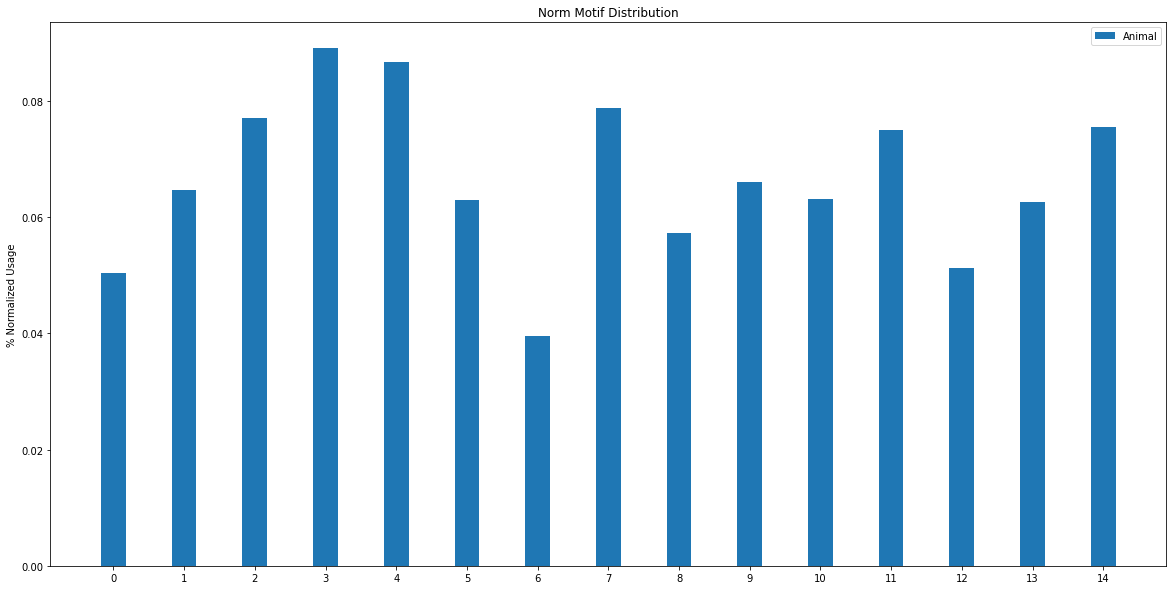

In [10]:
# display the distribution of behavioral motifs
behavior_distribution(config,param='kmeans')

In [ ]:
markov_graph_analysis(config, param='kmeans', threshold=0.00)

In [ ]:
create_tree_representation(config, param='kmeans')

The tree or hierarchical representation can help you to group motifs into communities or categories. For the next part of the analysis, you should group the tree. This needs to be done by hand. Therefore, please fill out the list below with the tree labels from left to right. Example:

                                    root
                                  /      \
                                 o        o
                                / \      / \ 
                               4   o    1   3
                                  / \
                                 5   2
                              
community_order = [4,5,2,1,3]

In [ ]:
community_order = [13,14,7,0,12,8,4,10,1,11,6,5,3,9,2]

In [ ]:
community_ordered_transition_probabilities(config, community_order, param='kmeans', threshold=0.0)

In [ ]:
import umap